In [8]:
import os
import numpy as np
from matplotlib import pyplot as mp
import cv2 as cv
from scipy import integrate, interpolate as interp, signal as sig
from jupyterthemes import jtplot

In [9]:
jtplot.reset()
mp.style.use("seaborn")
mp.rcParams["axes.axisbelow"] = True
mp.rcParams["text.usetex"] = True
mp.rcParams["font.family"] = "serif"
mp.rcParams["figure.figsize"] = (16/2, 9/2)
mp.rcParams["figure.dpi"] = 100
mp.rcParams["text.latex.preamble"] = [r"\usepackage{physics}", r"\usepackage{url}"]

In [13]:
def spec2xyz(wavelength, spectrum, observer):
    XYZ = []
    for i in range(len(observer)):
        integrand = spectrum*observer[i]
        integral = integrate.trapz(integrand, wavelength)
        XYZ.append(integral)
    x, y, z = XYZ/np.sum(XYZ)
    return x, y

def ShoelaceArea(x, y):
    return 1/2 * abs(x@np.roll(y, 1) - y@np.roll(x, 1))

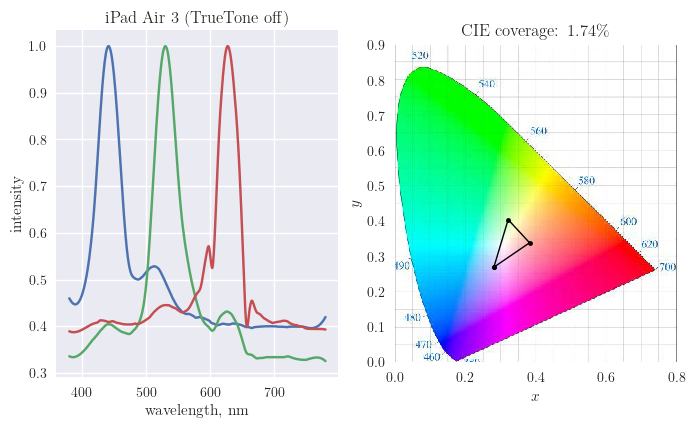

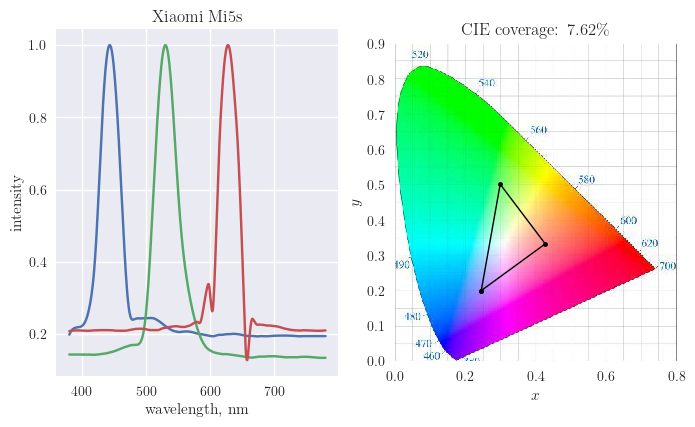

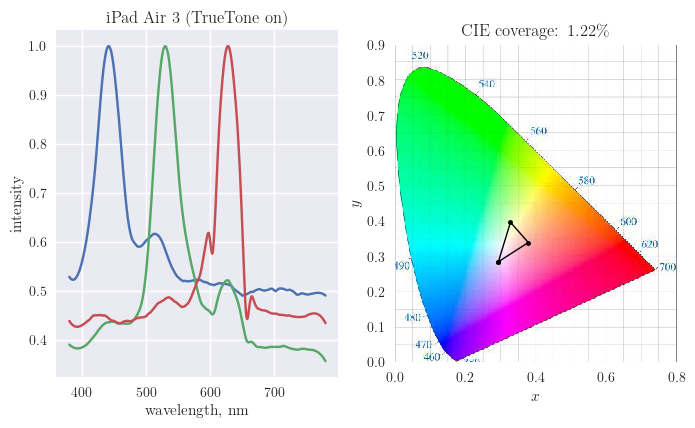

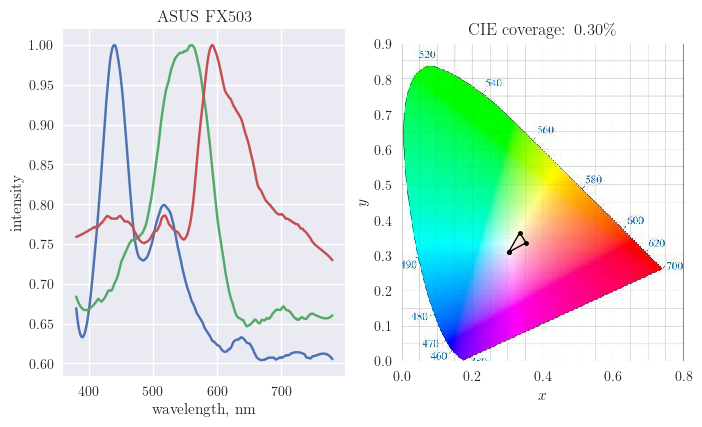

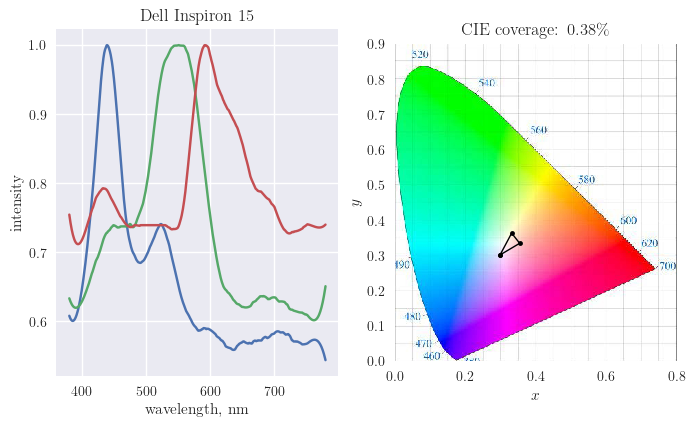

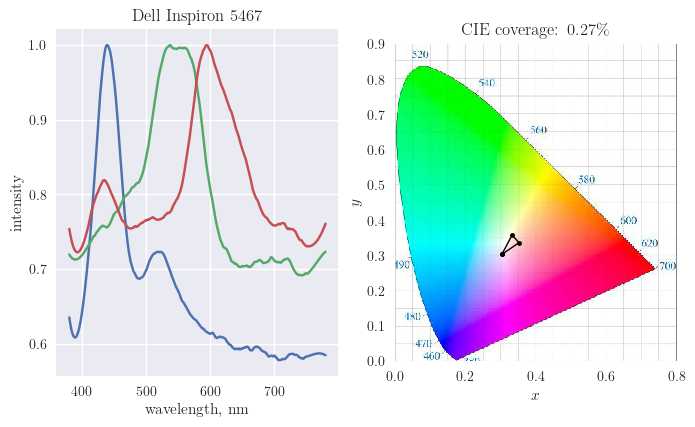

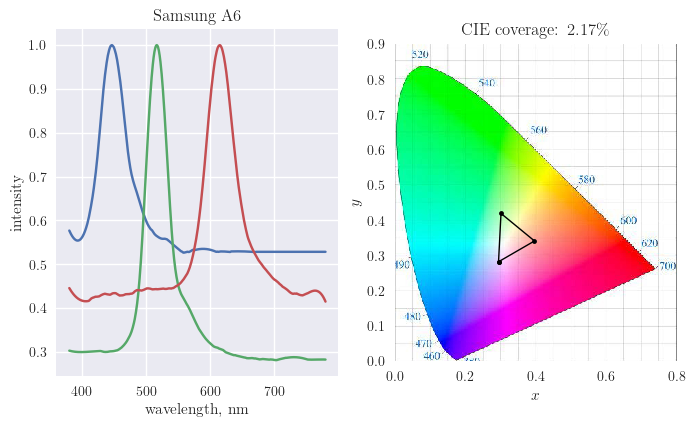

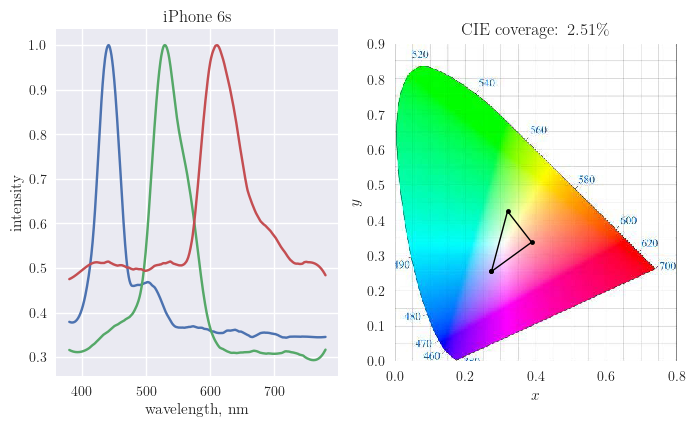

In [21]:
filenames = os.listdir()
prefix = ['charles_', 'charlesp_', 'charlestt_',
          'ken_', 'mc_', 'viron_', 'vironp_', 'ymmanp_']
devices = ['iPad Air 3 (TrueTone off)', 'Xiaomi Mi5s', 
           'iPad Air 3 (TrueTone on)', 'ASUS FX503', 
           'Dell Inspiron 15', 'Dell Inspiron 5467', 
           'Samsung A6', 'iPhone 6s']
ciexy = mp.imread('ciexy.jpg')
cie_wl, xbar, ybar, zbar = np.genfromtxt('cie1964.csv', delimiter=',', unpack=True)
tongue_area = 0.31333300377934403

for j, p in enumerate(prefix):
    boundx, boundy = [], []
    fig = mp.figure(figsize=(16/2, 9/2))
    ax = fig.add_subplot(121)
    for file in filenames:
        if file.startswith(p):
            wavelength, intensity = np.genfromtxt(file, unpack=True)

            overall_wlmin = max(cie_wl.min(), wavelength.min())
            overall_wlmax = min(cie_wl.max(), wavelength.max())
            overall_wllen = max(cie_wl.size, wavelength.size)

            xbar_interp = interp.interp1d(cie_wl, xbar)
            ybar_interp = interp.interp1d(cie_wl, ybar)
            zbar_interp = interp.interp1d(cie_wl, zbar)
            spec_interp = interp.interp1d(wavelength, intensity)

            wavelength = np.linspace(overall_wlmin, overall_wlmax, overall_wllen)
            intens = spec_interp(wavelength)
            xi = xbar_interp(wavelength)
            yi = ybar_interp(wavelength)
            zi = zbar_interp(wavelength)
            
            x, y = spec2xyz(wavelength, intens, [xi, yi, zi])
            boundx.append(x)
            boundy.append(y)
            
            intens = sig.savgol_filter(intens, 91, 3)
            intens /= intens.max()
            ax.plot(wavelength, intens)
    
    ax.set_title(devices[j])
    ax.set_xlabel('wavelength, nm')
    ax.set_ylabel('intensity')

    ax = fig.add_subplot(122)
    gamut_area = ShoelaceArea(boundx, boundy)
    boundx.append(boundx[0])
    boundy.append(boundy[0])
    ax.imshow(ciexy, extent=(0.0, 0.8, 0.0, 0.9))
    ax.plot(boundx, boundy, 'k.-', lw=1)
    
    cie_coverage = gamut_area/tongue_area * 100
    ax.grid(0)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_title('CIE coverage: {:.2f}\%'.format(cie_coverage))
    
    mp.savefig(''.join(devices[j].split(' ')) + '.png', dpi=300, bbox_inches='tight')
    mp.show()